## Loading Packages and Tables

In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import dask.dataframe as dd
import streamlit as st
import numpy as np

In [283]:
diag = pd.read_csv('C:\\Users\\yahya\\Documents\\GitHub\\Internship\\CSV_files\\diagnoses_table.csv', dtype={"icd_code": "object"})
#diag = pd.read_csv('../dataFiles/diagnoses_table.csv', dtype={"icd_code": "object"})

In [284]:
def detect_icd_version(code):
    code = str(code).strip().upper()
    return 10 if code and code[0].isalpha() else 9

# Apply to your DataFrame
diag['icd_version'] = diag['icd_code'].apply(detect_icd_version)

In [285]:
admission = pd.read_csv('C:\\Users\\Yahya\\Documents\\GitHub\\Internship\\CSV_files\\admissions_table.csv')
#admission = pd.read_csv('../dataFiles/admissions_table.csv')

In [286]:
diag_adm_table = diag.merge(admission, on=['subject_id', 'hadm_id'])
diag_adm_table = diag_adm_table.sort_values(by="subject_id")
diag_adm_table = diag_adm_table.reset_index(drop=True)

In [287]:
diag_adm_table.shape

(5071195, 6)

## Selecting CML patients

In [288]:
icd9 = diag_adm_table[diag_adm_table['icd_code'].str.match(r'^\d')]
filtered_icd9 = icd9[(icd9['icd_code'].astype(float) >= 20500) & (icd9['icd_code'].astype(float) <= 20592)]

In [289]:
filtered_icd9['icd_code'].value_counts()

icd_code
20500    924
20501    405
20510    260
20502    176
20511     67
20530     16
20512     10
20581      2
20580      2
20590      1
20531      1
20591      1
Name: count, dtype: int64

In [290]:
filtered_icd9.shape

(1865, 6)

In [291]:
icd10 = diag_adm_table[diag_adm_table['icd_code'].str.match(r'^[A-Z]')]
filtered_icd10 = icd10[icd10['icd_code'].str.startswith('C92')]

In [292]:
filtered_icd10.shape

(2134, 6)

In [293]:
diag_cml = pd.concat([filtered_icd9, filtered_icd10])
diag_cml = diag_cml.reset_index(drop=True)
diag_cml['icd_code'].value_counts()

icd_code
20500    924
C9200    803
C9201    429
20501    405
C9202    288
20510    260
C9210    219
20502    176
C9211     72
C92Z0     72
20511     67
C9230     55
C92Z1     43
C92Z2     37
C9240     29
20530     16
C9241     15
C92A0     12
C9290     11
20512     10
C9232     10
C9231     10
C9250      9
C9220      6
C9212      4
C9251      2
20581      2
C92A1      2
20580      2
20531      1
20591      1
20590      1
C9261      1
C9260      1
C9242      1
C9221      1
C9252      1
C92A2      1
Name: count, dtype: int64

In [294]:
diag_cml.shape

(3999, 6)

In [295]:
diag_cml

,subject_id,hadm_id,icd_code,icd_version,admittime,dischtime
0,10035631,20385771,20500,9,2112-12-04 00:00:00,2112-12-27 16:24:00
1,10035631,22732862,20500,9,2112-11-10 15:55:00,2112-11-20 16:20:00
2,10035631,24912093,20501,9,2112-10-22 00:00:00,2112-10-28 12:16:00
3,10035631,27496788,20500,9,2113-08-26 17:07:00,2113-08-29 15:18:00
4,10035631,29462354,20500,9,2112-09-17 19:13:00,2112-10-17 01:41:00
...,...,...,...,...,...,...
3994,19880967,29168432,C9202,10,2176-04-07 16:41:00,2176-04-28 15:34:00
3995,19880967,29316666,C9202,10,2175-12-28 18:41:00,2176-01-12 19:50:00
3996,19912102,27379197,C9210,10,2183-06-16 22:40:00,2183-07-06 19:35:00
3997,19912102,28143086,C9210,10,2185-08-16 01:21:00,2185-08-18 15:17:00


In [296]:
diag_cml.to_csv(r"C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\cml_diagnoses.csv", index=False)

In [297]:
print(f"Unique patient numbers: {diag_cml['subject_id'].nunique()}")

Unique patient numbers: 946


## Selecting all CVD patients

In [298]:
ICD_9_dict = {
    'hypertensive': range(401, 406, 1),
    'ischemic': range(410, 415, 1),
    'pulmonary': range(415, 418, 1),
    'other': range(420, 430, 1),
    'cerebrovascular': range(430, 439, 1),
    'arterioles': range(440, 450, 1),
    'any': list(range(401,406,1))+list(range(410,418,1))+list(range(420,450,1)), ### if the pateint has any kind of cvd
}

ICD_10_dict = {
    'hypertensive': ['I10', 'I11', 'I12', 'I13', 'I15'],
    'ischemic': ['I20', 'I21', 'I22', 'I23', 'I24', 'I25'],
    'pulmonary': ['I26', 'I27'],
    'other': ['I30', 'I31', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39'],
    'cerebrovascular': ['I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69'],
    'arterioles': ['I70', 'I71', 'I72', 'I73', 'I74', 'I77'],
    'any':['I10', 'I11', 'I12', 'I13', 'I15','I20', 'I21', 'I22', 'I23', 'I24', 'I25','I26', 'I27','I30', \
           'I31', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39','I60', 'I61', 'I62', 'I63', 'I64', 'I65', \
           'I66', 'I67', 'I68', 'I69','I70', 'I71', 'I72', 'I73', 'I74', 'I77']
}

In [299]:
### you do have a column called icd_version, you can use this column to choose the icd version

diag_icd9 = diag_adm_table[diag_adm_table['icd_version']==9]
diag_icd10 = diag_adm_table[diag_adm_table['icd_version']==10]

In [300]:
#### This part is not fully correct and very inefficient so I changed it ###

def add_cvd_variable(CVD_icd_codes,diag_table):
    numbers_string = tuple(str(num) for num in CVD_icd_codes)

    diag_cvd = diag_table[diag_table['icd_code'].str.startswith(numbers_string)]
    
    # patient_cvd = pd.DataFrame(diag_cvd.subject_id.drop_duplicates())

    return diag_cvd

In [301]:
### Adding CVD types to table for both ICD 9 and 10
diag_icd9_add_cvd = diag_icd9.copy()
diag_icd10_add_cvd = diag_icd10.copy()

for key in ICD_9_dict.keys():
    CVD_type = key
    ICD_CVD = ICD_9_dict[CVD_type]
    patient_cvd = add_cvd_variable(ICD_CVD,diag_icd9)

    diag_icd9_add_cvd.loc[:, CVD_type] = np.where(diag_icd9_add_cvd.hadm_id.isin(patient_cvd.hadm_id), 1, 0)

for key in ICD_10_dict.keys():
    CVD_type = key
    ICD_CVD = ICD_10_dict[CVD_type]
    patient_cvd = add_cvd_variable(ICD_CVD,diag_icd10)

    diag_icd10_add_cvd.loc[:, CVD_type] = np.where(diag_icd10_add_cvd.subject_id.isin(patient_cvd.subject_id), 1, 0)

In [302]:
### Merge ICD 9 and 10 into one table 

diag_cvd_full_table = pd.concat([diag_icd9_add_cvd, diag_icd10_add_cvd])
diag_cvd_full_table = diag_cvd_full_table.reset_index(drop=True)

diag_cvd_full_table = diag_cvd_full_table.drop(columns=['icd_code','icd_version', 'dischtime']).drop_duplicates()

In [303]:
diag_cvd_full_table.head()

,subject_id,hadm_id,admittime,hypertensive,ischemic,pulmonary,other,cerebrovascular,arterioles,any
0,10000032,29079034,2180-07-23 12:35:00,0,0,0,0,0,0,0
10,10000635,26134563,2136-06-19 14:24:00,1,0,0,1,0,0,1
13,10000690,23280645,2150-09-16 19:48:00,1,0,0,1,0,0,1
28,10000690,25860671,2150-11-02 18:02:00,1,1,0,1,0,0,1
49,10000690,26146595,2152-01-28 23:40:00,1,0,0,1,0,0,1


## Merging CML and CVD tables

In [304]:
### Remove icd_code and version from CML table and check the number of CML patients
diag_cml_full_table = diag_cml.drop(columns=['icd_code','icd_version','dischtime']).drop_duplicates()
diag_cml_full_table['admittime'] = pd.to_datetime(diag_cml_full_table['admittime'])
print("Number of CML patients is ", len(diag_cml['subject_id'].unique()))
### We keep the earlist diagnosis dates for CML patients
first_diag_cml = diag_cml_full_table.loc[diag_cml_full_table.groupby(['subject_id'])['admittime'].idxmin()]

Number of CML patients is  946


In [305]:
### Check if all patients admissions in CML table are also in the CVD table
first_diag_cml['hadm_id'].isin(diag_cvd_full_table['hadm_id']).all() #subject_id

np.True_

In [306]:
### Since we have several categories of CVD, let's pick one of them. 

Selected_CVD_type = "other" # from hypertensive, ischemic, pulmonary, other, cerebrovascular, arterioles, any

def make_cvd_cml_patient_table(Selected_CVD_type, diag_cvd_full_table, first_diag_cml):
    
    diag_cvd_light_table = diag_cvd_full_table[['subject_id','admittime',Selected_CVD_type]].copy()
    diag_cvd_light_table = diag_cvd_light_table[diag_cvd_light_table[Selected_CVD_type]==1]
    diag_cvd_light_table['admittime'] = pd.to_datetime(diag_cvd_light_table['admittime'], errors='coerce')
    first_diag_cvd = diag_cvd_light_table.loc[diag_cvd_light_table.groupby(['subject_id'])['admittime'].idxmin()]
    print(f'Number of {Selected_CVD_type} patients is {first_diag_cvd.subject_id.nunique()}')
    
    ### Let change the column names
    first_diag_cml = first_diag_cml.rename(columns={'admittime': 'cml_date'})
    first_diag_cvd = first_diag_cvd.rename(columns={'admittime': 'cvd_date'})
    
    
    ### Merge CML with CVD table. in the "how" parameter, left --> we keep all CML patient. right--> we keep all CVD patients
    ### For now, we focus on CML patients and how they develop CVDs
    merged_cml_cvd_table = first_diag_cml.merge(first_diag_cvd, on=['subject_id'], how='left')
    merged_cml_cvd_table['cml_date'] = pd.to_datetime(merged_cml_cvd_table['cml_date'])
    merged_cml_cvd_table['cvd_date'] = pd.to_datetime(merged_cml_cvd_table['cvd_date'])
    # merged_cml_cvd_table
    
    merged_cml_cvd_table.loc[:, f'has_future_{Selected_CVD_type}'] = (merged_cml_cvd_table['cvd_date'] > merged_cml_cvd_table['cml_date']).astype(int)
    merged_cml_cvd_table.loc[:, f'has_immediate_{Selected_CVD_type}'] = (merged_cml_cvd_table['cvd_date'] == merged_cml_cvd_table['cml_date']).astype(int)
    merged_cml_cvd_table.loc[:, f'has_{Selected_CVD_type}'] = (merged_cml_cvd_table['cvd_date'] >= merged_cml_cvd_table['cml_date']).astype(int)
    merged_cml_cvd_table.loc[:, f'has_{Selected_CVD_type}_before_cml'] = (merged_cml_cvd_table['cvd_date'] < merged_cml_cvd_table['cml_date']).astype(int)
    # ### Calculate the durations (by months) between CVD diagnosis and CML diagnosis
    merged_cml_cvd_table['duration_cvd'] = (merged_cml_cvd_table['cvd_date']-merged_cml_cvd_table['cml_date']).dt.days / 30.44

    return merged_cml_cvd_table

In [307]:
merged_cml_cvd_table = make_cvd_cml_patient_table(Selected_CVD_type, diag_cvd_full_table, first_diag_cml)

Number of other patients is 44347


In [308]:
print(f"Patients got {Selected_CVD_type} after CML: \n{merged_cml_cvd_table[f'has_future_{Selected_CVD_type}'].value_counts()}")
print(f"Patients got {Selected_CVD_type} with CML: \n{merged_cml_cvd_table[f'has_immediate_{Selected_CVD_type}'].value_counts()}")
print(f"Patients got {Selected_CVD_type} before CML: \n{merged_cml_cvd_table[f'has_{Selected_CVD_type}_before_cml'].value_counts()}")
print(f"Patients got {Selected_CVD_type} after or with CML: \n{merged_cml_cvd_table[f'has_{Selected_CVD_type}'].value_counts()}")
print(f"Patients NO {Selected_CVD_type} with CML: \n{merged_cml_cvd_table['duration_cvd'].isnull().sum()}")

Patients got other after CML: 
has_future_other
0    878
1     68
Name: count, dtype: int64
Patients got other with CML: 
has_immediate_other
0    763
1    183
Name: count, dtype: int64
Patients got other before CML: 
has_other_before_cml
0    846
1    100
Name: count, dtype: int64
Patients got other after or with CML: 
has_other
0    695
1    251
Name: count, dtype: int64
Patients NO other with CML: 
595


### Feel free to use visualizations in your report and presentation

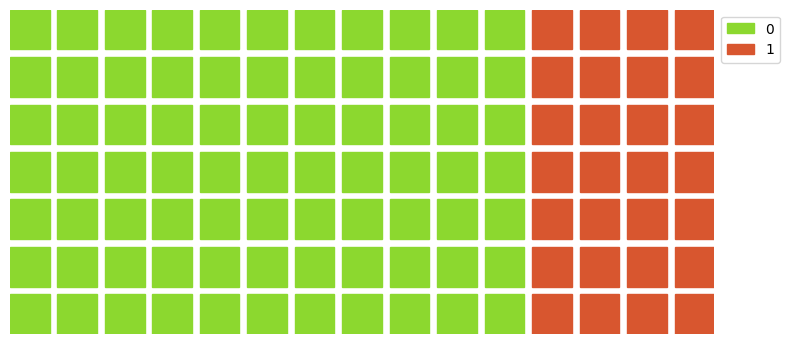

In [309]:
from pywaffle import Waffle
binary_fig=plt.figure(
        figsize=(8, 6),
        colors=["#8cd82f","#d8562f"],
        FigureClass=Waffle,
        rows=7,
        columns=15,
        values=dict(merged_cml_cvd_table[f'has_{Selected_CVD_type}'].value_counts()),
        font_size=30,
        legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
    )

## The code above should be correct now!!! ##

## Loading and Preprosessing Labevents data

In [310]:
lab = pd.read_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\labevents_combined.csv', dtype={"icd_code": "object"})
#lab = pd.read_csv('../dataFiles/labevents_combined.csv', dtype={"icd_code": "object"})

In [311]:
diag_cml_lab = merged_cml_cvd_table.merge(lab, on=['subject_id'])

In [312]:
diag_cml_lab = diag_cml_lab.reset_index(drop=True)

In [313]:
diag_cml_lab = diag_cml_lab.drop(columns=['charttime'])

In [314]:
diag_cml_lab = diag_cml_lab.drop_duplicates()

In [315]:
diag_cml_lab

,subject_id,hadm_id_x,cml_date,cvd_date,other,has_future_other,has_immediate_other,has_other,has_other_before_cml,duration_cvd,hadm_id_y,label,valuenum,valueuom
0,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,27998273,Absolute Neutrophil Count,1.85,K/uL
1,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,28743978,Absolute Basophil Count,0.00,K/uL
2,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,29368887,Absolute Eosinophil Count,0.00,K/uL
3,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,27998273,Bands,0.00,%
4,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,25499227,Bands,0.00,%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918271,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,25909426,Lactate Dehydrogenase (LD),218.00,IU/L
2918272,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,25909426,Lymphocytes,53.00,%
2918273,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,25909426,Lymphocytes,34.00,%
2918274,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,25909426,Monocytes,6.00,%


## Loading and Preprosessing Pharmacy data

In [316]:
pharm = pd.read_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\pharmacy_table.csv', dtype={"icd_code": "object"})
# pharm = pd.read_csv('../dataFiles/pharmacy_table.csv', dtype={"icd_code": "object"})

In [317]:
pharm.rename(columns={'duration':'duration_med'}, inplace=True)

In [318]:
pharm = pharm.drop(columns=['starttime', 'stoptime', 'hadm_id'])

In [319]:
drug_mapping = {
    'imatinib': 'Imatinib',
    'imatinib mesylate': 'Imatinib',
    '*nf* imatinib mesylate': 'Imatinib',
    'imatinib oral suspension': 'Imatinib',
    'imatinib (gleevec)': 'Imatinib',
    'dasatinib': 'Dasatinib',
    'dasatinib 20mg tablet': 'Dasatinib',
    '*nf* dasatinib': 'Dasatinib',
    'ruxolitinib': 'Ruxolitinib',
    'inv-ruxolitinib': 'Ruxolitinib',
    'nilotinib': 'Nilotinib',
    '*nf* nilotinib': 'Nilotinib',
    'cabozantinib': 'Cabozantinib',
    'inv-cabozatinib': 'Cabozantinib',
    'ruxolitinib ':'Ruxolitinib',
    'inv-cabozantinib (cabozantinib)': 'Cabozantinib',
    'crizotinib': 'Crizotinib'
}

In [320]:
pharm['medication_norm'] = pharm['medication'].str.lower().map(drug_mapping)


In [321]:
pharm['medication_norm'].value_counts(dropna=False)

medication_norm
NaN             8733956
Ruxolitinib         534
Imatinib            284
Dasatinib           209
Nilotinib            59
Cabozantinib         40
Crizotinib           27
Name: count, dtype: int64

In [322]:
doses = pd.read_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\drug_doses.csv')
doses

,subject_id,drug,dose_val_rx,dose_unit_rx
0,10019003,ruxolitinib,5.0,mg
1,10019003,ruxolitinib,5.0,mg
2,10019003,ruxolitinib,5.0,mg
3,10019003,ruxolitinib,5.0,mg
4,10019003,ruxolitinib,5.0,mg
...,...,...,...,...
21153,19940147,nilotinib,150.0,mg
21154,19940147,nilotinib,300.0,mg
21155,19940147,nilotinib,400.0,mg
21156,19940147,nilotinib,150.0,mg


In [323]:
doses.rename(columns={'dose_val_rx': 'prescribed_dose'}, inplace=True)

In [324]:
doses['medication_norm'] = doses['drug'].str.lower().map(drug_mapping)

In [325]:
doses

,subject_id,drug,prescribed_dose,dose_unit_rx,medication_norm
0,10019003,ruxolitinib,5.0,mg,Ruxolitinib
1,10019003,ruxolitinib,5.0,mg,Ruxolitinib
2,10019003,ruxolitinib,5.0,mg,Ruxolitinib
3,10019003,ruxolitinib,5.0,mg,Ruxolitinib
4,10019003,ruxolitinib,5.0,mg,Ruxolitinib
...,...,...,...,...,...
21153,19940147,nilotinib,150.0,mg,Nilotinib
21154,19940147,nilotinib,300.0,mg,Nilotinib
21155,19940147,nilotinib,400.0,mg,Nilotinib
21156,19940147,nilotinib,150.0,mg,Nilotinib


In [326]:
pharm = pharm.merge(
    doses[['subject_id', 'medication_norm', 'prescribed_dose']],
    how='left',
    on=['subject_id', 'medication_norm']
)

In [327]:
pharm

,subject_id,medication,frequency,doses_per_24_hrs,duration_med,duration_interval,medication_norm,prescribed_dose
0,19044308,Hemorrhoidal Suppository,X1,1,NaN,Ongoing,NaN,NaN
1,19418856,Dextrose 50%,PRN,0,NaN,Ongoing,NaN,NaN
2,14675722,Dextrose 10% in Water (D10W),PRN,0,NaN,Ongoing,NaN,NaN
3,11875773,Heparin (Hemodialysis),Q1H,24,NaN,Ongoing,NaN,NaN
4,11925629,Lactulose,Q2H,12,NaN,Ongoing,NaN,NaN
...,...,...,...,...,...,...,...,...
9435490,18172623,Dexmedetomidine,TITRATE TO RASS,0,NaN,Ongoing,NaN,NaN
9435491,19732085,Propofol,TITRATE TO RASS,0,NaN,Ongoing,NaN,NaN
9435492,16266305,Propofol,TITRATE TO RASS,0,NaN,Ongoing,NaN,NaN
9435493,15012461,Propofol,TITRATE TO RASS,0,NaN,Ongoing,NaN,NaN


In [328]:
pharm_dummies = pd.get_dummies(pharm['medication_norm'])

In [329]:
pharm = pd.concat([pharm, pharm_dummies], axis=1)

In [330]:
pharm = pharm.drop(columns=['medication', 'medication_norm'])
pharm = pharm.reset_index(drop=True)

In [331]:
pharm[['Cabozantinib', 'Crizotinib', 'Dasatinib', 'Imatinib', 'Nilotinib', 'Ruxolitinib']].value_counts()

Cabozantinib  Crizotinib  Dasatinib  Imatinib  Nilotinib  Ruxolitinib
False         False       False      False     False      False          8733956
                                                          True            666399
                                     True      False      False            21307
                          True       False     False      False             9748
                          False      False     True       False             2546
              True        False      False     False      False              799
True          False       False      False     False      False              740
Name: count, dtype: int64

In [332]:
pharm_diag = merged_cml_cvd_table.merge(pharm, on=['subject_id'])

In [333]:
pharm = pharm_diag.drop_duplicates()

In [334]:
pharm

,subject_id,hadm_id,cml_date,cvd_date,other,has_future_other,has_immediate_other,has_other,has_other_before_cml,duration_cvd,...,doses_per_24_hrs,duration_med,duration_interval,prescribed_dose,Cabozantinib,Crizotinib,Dasatinib,Imatinib,Nilotinib,Ruxolitinib
0,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,...,1,NaN,Ongoing,NaN,False,False,False,False,False,False
1,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,...,1,1.0,Doses,NaN,False,False,False,False,False,False
3,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,...,2,NaN,Ongoing,NaN,False,False,False,False,False,False
9,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,...,0,NaN,Ongoing,NaN,False,False,False,False,False,False
11,10010231,25499227,2117-11-08 20:21:00,NaT,NaN,0,0,0,0,NaN,...,1,1.0,Doses,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810178,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,...,1,5.0,Doses,NaN,False,False,False,False,False,False
810179,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,...,1,5.0,Days,NaN,False,False,False,False,False,False
810180,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,...,3,NaN,Ongoing,NaN,False,False,False,False,False,False
810181,19998562,25909426,2166-03-21 22:39:00,2166-03-16 14:56:00,1.0,0,0,0,1,-0.197109,...,2,NaN,Ongoing,NaN,False,False,False,False,False,False


In [335]:
import gc

gc.collect()

7478

In [336]:
diag_cml_lab.to_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\diag_cml_lab.csv')

In [337]:
pharm.to_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\pharm.csv')